<a href="https://colab.research.google.com/github/jpgill86/JG20-analysis/blob/master/JG20_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [0]:
!pip install -q neurotic

# Import Packages

In [0]:
import numpy as np
import quantities as pq
import pandas as pd
import neurotic

pq.markup.config.use_unicode = True  # allow symbols like mu for micro in output
pq.mN = pq.UnitQuantity('millinewton', pq.N/1e3, symbol = 'mN');  # define millinewton

import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive and Load Metadata File

Mount Google Drive:

In [23]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Load the *neurotic* metadata file from Google Drive:

In [0]:
metadata_file = '/gdrive/Shared drives/LFI-neural-correlates/Mirror of GIN data repository/LFI-neural-correlates/LFI-neural-correlates-metadata.yml'
metadata = neurotic.MetadataSelector(file=metadata_file)

List the available datasets:

In [25]:
metadata.keys

['IN VIVO / JG19 / 2020-02-17 / 001',
 'IN VIVO / JG19 / 2020-02-17 / 002',
 'IN VIVO / JG19 / 2020-02-18 / 001',
 'IN VIVO / JG19 / 2020-02-18 / 002',
 'IN VIVO / JG19 / 2020-02-19 / 001',
 'IN VIVO / JG19 / 2020-02-20 / 001',
 'IN VIVO / JG20 / 2020-02-24 / 001',
 'IN VIVO / JG20 / 2020-02-25 / 001',
 'IN VIVO / JG20 / 2020-02-25 / 002',
 'IN VIVO / JG20 / 2020-02-26 / 001',
 'IN VIVO / JG20 / 2020-02-26 / 002',
 'IN VIVO / JG20 / 2020-02-28 / 001',
 'IN VIVO / DJ1 / 2020-02-28 / 001',
 'IN VIVO / DJ1 / 2020-02-28 / 002',
 'IN VIVO / DJ1 / 2020-02-29 / 001',
 'IN VIVO / DJ1 / 2020-03-02 / 001',
 'IN VIVO / DJ3 / 2020-04-04 / 002',
 'IN VIVO / DJ3 / 2020-04-04 / 003',
 'IN VIVO / DJ3 / 2020-04-05 / 001',
 'IN VIVO / DJ3 / 2020-04-05 / 002',
 'IN VIVO / DJ3 / 2020-04-07 / 001']

# Define Functions

In [0]:
def quantify_spiketrain(label, unit, time_windows):

    results = []
    last_loaded_dataset = None

    for i, (dataset, (t_start, t_stop)) in enumerate(time_windows):
        if dataset is last_loaded_dataset:
            # skip loading the dataset since it is already in memory
            pass
        else:
            last_loaded_dataset = dataset

            # read the AxoGraph file and detect spikes
            metadata.select(dataset)
            blk = neurotic.load_dataset(metadata, lazy=False)

            # get the spike train
            spiketrain = next((st for st in blk.segments[0].spiketrains if st.name==unit), None)
            assert spiketrain is not None, f'The neuron named "{unit}" was not found among this list of detected spikes: {[st.name for st in blk.segments[0].spiketrains]}'

        # remove spikes outside the time range and make sure there are at least 2
        st = spiketrain.time_slice(t_start*pq.s, t_stop*pq.s)
        num_spikes = st.size
        if num_spikes < 2:
            burst_duration = 0*pq.s
            mean_firing_freq = 0*pq.Hz
        else:
            first_spike = st[0]
            last_spike = st[-1]
            burst_duration = (last_spike-first_spike).rescale('s')
            mean_firing_freq = ((num_spikes-1)/(burst_duration)).rescale('Hz')
    
        results += [(label, unit, i, dataset, t_start, t_stop, num_spikes, float(burst_duration), float(mean_firing_freq))]

    columns = ['Label', 'Unit', 'Index', 'Dataset', 't_start', 't_stop', 'Number of spikes', 'Burst duration (s)', 'Mean firing frequency (Hz)']
    df = pd.DataFrame(results, columns=columns)
    return df

# Import and Process the Data

In [0]:
df_dict = {}

## EN, Edible Food

In [28]:
label = 'Edible'
unit = 'EN small'

# specify the datasets and times when to quantify the unit activity
time_windows = [
                # Feb 24, Chart 001, swallowing regular nori
                ('IN VIVO / JG20 / 2020-02-24 / 001', [1766, 1770]),
                ('IN VIVO / JG20 / 2020-02-24 / 001', [1772, 1776]),
                ('IN VIVO / JG20 / 2020-02-24 / 001', [1781, 1784]),
                ('IN VIVO / JG20 / 2020-02-24 / 001', [1787, 1790]),

                # Feb 26, Chart 001, swallowing regular nori
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1081.46, 1085.46]),
                # ('IN VIVO / JG20 / 2020-02-26 / 001', [1087.46, 1090.46]), # frequency outlier (spike double counted?)
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1091.5, 1092.5]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1098.46, 1100.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1102.46, 1105.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1109.46, 1111.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1113.46, 1116.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1119.46, 1122.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1127.46, 1131.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1133.46, 1137.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1139.46, 1142.46]),
                # ('IN VIVO / JG20 / 2020-02-26 / 001', [1169.46, 1174.46]), # bite
                # ('IN VIVO / JG20 / 2020-02-26 / 001', [1187.46, 1189.46]), # bite
                # ('IN VIVO / JG20 / 2020-02-26 / 001', [1198.46, 1201.46]), # bite
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1274.46, 1278.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1282.46, 1284.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1286.46, 1289.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1293.46, 1296.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1299.46, 1302.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1503.46, 1506.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1509.46, 1512.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1515.46, 1519.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1521.46, 1524.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1526.46, 1531.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1534.46, 1541.46]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1654.97, 1657.97]),
                ]

df_dict[(label, unit)] = quantify_spiketrain(label, unit, time_windows)
df_dict[(label, unit)]

,Label,Unit,Index,Dataset,t_start,t_stop,Number of spikes,Burst duration (s),Mean firing frequency (Hz)
0,Edible,EN small,0,IN VIVO / JG20 / 2020-02-24 / 001,1766.00,1770.00,9,2.6446,3.025032
1,Edible,EN small,1,IN VIVO / JG20 / 2020-02-24 / 001,1772.00,1776.00,6,1.8112,2.760601
2,Edible,EN small,2,IN VIVO / JG20 / 2020-02-24 / 001,1781.00,1784.00,5,1.7778,2.249972
3,Edible,EN small,3,IN VIVO / JG20 / 2020-02-24 / 001,1787.00,1790.00,6,1.7512,2.855185
4,Edible,EN small,4,IN VIVO / JG20 / 2020-02-26 / 001,1081.46,1085.46,2,1.1512,0.868659
5,Edible,EN small,5,IN VIVO / JG20 / 2020-02-26 / 001,1091.50,1092.50,0,0.0000,0.000000
6,Edible,EN small,6,IN VIVO / JG20 / 2020-02-26 / 001,1098.46,1100.46,1,0.0000,0.000000
7,Edible,EN small,7,IN VIVO / JG20 / 2020-02-26 / 001,1102.46,1105.46,4,1.5342,1.955417
8,Edible,EN small,8,IN VIVO / JG20 / 2020-02-26 / 001,1109.46,1111.46,5,1.1816,3.385240
9,Edible,EN small,9,IN VIVO / JG20 / 2020-02-26 / 001,1113.46,1116.46,5,1.5128,2.644104


## EN, Netted Food

In [29]:
label = 'Netted'
unit = 'EN small'

# specify the datasets and times when to quantify the unit activity
time_windows = [
                # Feb 26, Chart 001, swallowing netted nori
                ('IN VIVO / JG20 / 2020-02-26 / 001', [373.7, 374.7]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [380.7, 383.7]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [389.7, 390.7]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [396.7, 398.7]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [408.2, 410.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [432.2, 436.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [460.2, 462.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [466.2, 468.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [479.2, 481.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [494.2, 496.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [501.2, 503.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [534.2, 536.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [541.2, 543.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [547.2, 550.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [561.2, 564.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [583.2, 585.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [591.2, 593.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [664.2, 666.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [680.2, 684.2]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [688.3, 690.3]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [706.3, 708.3]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [764.3, 765.3]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [777.3, 779.3]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [788.3, 794.3]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [856.3, 857.3]),
                ]

df_dict[(label, unit)] = quantify_spiketrain(label, unit, time_windows)
df_dict[(label, unit)]

,Label,Unit,Index,Dataset,t_start,t_stop,Number of spikes,Burst duration (s),Mean firing frequency (Hz)
0,Netted,EN small,0,IN VIVO / JG20 / 2020-02-26 / 001,373.7,374.7,1,0.0000,0.000000
1,Netted,EN small,1,IN VIVO / JG20 / 2020-02-26 / 001,380.7,383.7,2,1.7048,0.586579
2,Netted,EN small,2,IN VIVO / JG20 / 2020-02-26 / 001,389.7,390.7,1,0.0000,0.000000
3,Netted,EN small,3,IN VIVO / JG20 / 2020-02-26 / 001,396.7,398.7,2,0.3654,2.736727
4,Netted,EN small,4,IN VIVO / JG20 / 2020-02-26 / 001,408.2,410.2,2,0.5856,1.707650
5,Netted,EN small,5,IN VIVO / JG20 / 2020-02-26 / 001,432.2,436.2,2,2.0134,0.496672
6,Netted,EN small,6,IN VIVO / JG20 / 2020-02-26 / 001,460.2,462.2,2,0.1578,6.337136
7,Netted,EN small,7,IN VIVO / JG20 / 2020-02-26 / 001,466.2,468.2,2,0.7544,1.325557
8,Netted,EN small,8,IN VIVO / JG20 / 2020-02-26 / 001,479.2,481.2,2,0.7138,1.400953
9,Netted,EN small,9,IN VIVO / JG20 / 2020-02-26 / 001,494.2,496.2,1,0.0000,0.000000


## EN, Tape nori

In [0]:
# label = 'Tape nori'
# unit = 'EN small'

# # specify the datasets and times when to quantify the unit activity
# time_windows = [
#                 ]

# df_dict[(label, unit)] = quantify_spiketrain(label, unit, time_windows)
# df_dict[(label, unit)]

## EN, Biting

In [0]:
# label = 'Biting'
# unit = 'EN small'

# # specify the datasets and times when to quantify the unit activity
# time_windows = [
#                 # Feb 26, Chart 001, biting on chopsticks
#                 # t=1382-1473 is a really good sequence that is worth including
#                 ]

# df_dict[(label, unit)] = quantify_spiketrain(label, unit, time_windows)
# df_dict[(label, unit)]

## MCC, Edible Food

In [32]:
label = 'Edible'
unit = 'MCC'

# specify the datasets and times when to quantify the unit activity
time_windows = [
                # Feb 26, Chart 001, biting/swallowing regular nori
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1072.5, 1077.5]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1079.5, 1086.5]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1087.9, 1097.9]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1104.9, 1115.9]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1120.9, 1130.9]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1130.9, 1135.9]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1136.9, 1142.9]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1145.9, 1150.9]),

                # Feb 26, Chart 002, biting/swallowing regular nori
                ('IN VIVO / JG20 / 2020-02-26 / 002', [2820, 2826]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [2827, 2832]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [2836, 2843]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [2845, 2850]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [2851, 2857]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [2858, 2863]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [2864, 2870]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [2872, 2878]),
                
                # Feb 28, Chart 001, biting/swallowing regular nori
                ('IN VIVO / JG20 / 2020-02-28 / 001', [2112, 2121]),
                ('IN VIVO / JG20 / 2020-02-28 / 001', [2122, 2131]),
                ('IN VIVO / JG20 / 2020-02-28 / 001', [2132, 2139]),
                ('IN VIVO / JG20 / 2020-02-28 / 001', [2140, 2153]),
                ('IN VIVO / JG20 / 2020-02-28 / 001', [2154, 2168]),
                ('IN VIVO / JG20 / 2020-02-28 / 001', [2169, 2172]),
                ('IN VIVO / JG20 / 2020-02-28 / 001', [3511, 3522]),
                ('IN VIVO / JG20 / 2020-02-28 / 001', [3528, 3542]),

                # Feb 26, Chart 001, biting/swallowing (Single swallow) regular nori
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1647, 1651]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1652, 1657]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1658, 1662]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [1663, 1668]),
                ]

df_dict[(label, unit)] = quantify_spiketrain(label, unit, time_windows)
df_dict[(label, unit)]

,Label,Unit,Index,Dataset,t_start,t_stop,Number of spikes,Burst duration (s),Mean firing frequency (Hz)
0,Edible,MCC,0,IN VIVO / JG20 / 2020-02-26 / 001,1072.5,1077.5,17,4.7428,3.373535
1,Edible,MCC,1,IN VIVO / JG20 / 2020-02-26 / 001,1079.5,1086.5,8,5.6860,1.231094
2,Edible,MCC,2,IN VIVO / JG20 / 2020-02-26 / 001,1087.9,1097.9,14,9.7138,1.338302
3,Edible,MCC,3,IN VIVO / JG20 / 2020-02-26 / 001,1104.9,1115.9,9,9.1428,0.875005
4,Edible,MCC,4,IN VIVO / JG20 / 2020-02-26 / 001,1120.9,1130.9,4,4.7234,0.635136
5,Edible,MCC,5,IN VIVO / JG20 / 2020-02-26 / 001,1130.9,1135.9,8,3.8578,1.814506
6,Edible,MCC,6,IN VIVO / JG20 / 2020-02-26 / 001,1136.9,1142.9,5,4.3102,0.928031
7,Edible,MCC,7,IN VIVO / JG20 / 2020-02-26 / 001,1145.9,1150.9,3,4.7830,0.418148
8,Edible,MCC,8,IN VIVO / JG20 / 2020-02-26 / 002,2820.0,2826.0,10,5.1108,1.760977
9,Edible,MCC,9,IN VIVO / JG20 / 2020-02-26 / 002,2827.0,2832.0,4,3.6404,0.824085


## MCC, Netted Food

In [33]:
label = 'Netted'
unit = 'MCC'

# specify the datasets and times when to quantify the unit activity
time_windows = [
                # Feb 26, Chart 001, biting/swallowing netted nori
                ('IN VIVO / JG20 / 2020-02-26 / 001', [322, 328]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [329, 334]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [373, 381]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [382, 389]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [663, 672]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [674, 679]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [688, 695]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [696, 702]),

                # Feb 25, Chart 001, biting/swallowing netted nori
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1761.6, 1772.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1793.6, 1804.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1810.6, 1818.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1820.6, 1830.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1854.6, 1870.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1872.6, 1881.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1906.6, 1915.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1918.6, 1930.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1931.6, 1938.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1939.6, 1946.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1948.6, 1962.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1963.6, 1967.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [1998.6, 2011.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [2013.6, 2028.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [2032.6, 2045.6]),
                ('IN VIVO / JG20 / 2020-02-25 / 001', [2052.6, 2078.6]),

                # Feb 26, Chart 001, biting/swallowing (single swallow) netted nori
                ('IN VIVO / JG20 / 2020-02-26 / 001', [365, 372]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [373, 382]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [382, 388]),
                ('IN VIVO / JG20 / 2020-02-26 / 001', [390, 396]),
                ]

df_dict[(label, unit)] = quantify_spiketrain(label, unit, time_windows)
df_dict[(label, unit)]

,Label,Unit,Index,Dataset,t_start,t_stop,Number of spikes,Burst duration (s),Mean firing frequency (Hz)
0,Netted,MCC,0,IN VIVO / JG20 / 2020-02-26 / 001,322.0,328.0,9,5.1716,1.546910
1,Netted,MCC,1,IN VIVO / JG20 / 2020-02-26 / 001,329.0,334.0,8,4.2562,1.644660
2,Netted,MCC,2,IN VIVO / JG20 / 2020-02-26 / 001,373.0,381.0,8,7.4968,0.933732
3,Netted,MCC,3,IN VIVO / JG20 / 2020-02-26 / 001,382.0,389.0,7,5.7826,1.037596
4,Netted,MCC,4,IN VIVO / JG20 / 2020-02-26 / 001,663.0,672.0,2,4.6544,0.214850
5,Netted,MCC,5,IN VIVO / JG20 / 2020-02-26 / 001,674.0,679.0,4,2.9004,1.034340
6,Netted,MCC,6,IN VIVO / JG20 / 2020-02-26 / 001,688.0,695.0,6,4.0398,1.237685
7,Netted,MCC,7,IN VIVO / JG20 / 2020-02-26 / 001,696.0,702.0,4,3.3836,0.886630
8,Netted,MCC,8,IN VIVO / JG20 / 2020-02-25 / 001,1761.6,1772.6,8,9.7984,0.714402
9,Netted,MCC,9,IN VIVO / JG20 / 2020-02-25 / 001,1793.6,1804.6,5,9.3754,0.426648


## MCC, Tape nori

In [34]:
label = 'Tape nori'
unit = 'MCC'

# specify the datasets and times when to quantify the unit activity
time_windows = [
                # Feb 26, Chart 002, biting/swallowing tape nori
                ('IN VIVO / JG20 / 2020-02-26 / 002', [542.6, 547.6]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [553.6, 560.6]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [590.6, 597.6]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [641.6, 644.6]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [702.6, 713.6]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [714.6, 721.6]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [728.6, 732.6]),
                ('IN VIVO / JG20 / 2020-02-26 / 002', [754.6, 760.6]),
                ]

df_dict[(label, unit)] = quantify_spiketrain(label, unit, time_windows)
df_dict[(label, unit)]

,Label,Unit,Index,Dataset,t_start,t_stop,Number of spikes,Burst duration (s),Mean firing frequency (Hz)
0,Tape nori,MCC,0,IN VIVO / JG20 / 2020-02-26 / 002,542.6,547.6,6,2.5766,1.940542
1,Tape nori,MCC,1,IN VIVO / JG20 / 2020-02-26 / 002,553.6,560.6,9,5.5546,1.440248
2,Tape nori,MCC,2,IN VIVO / JG20 / 2020-02-26 / 002,590.6,597.6,4,3.9110,0.767067
3,Tape nori,MCC,3,IN VIVO / JG20 / 2020-02-26 / 002,641.6,644.6,2,1.6178,0.618123
4,Tape nori,MCC,4,IN VIVO / JG20 / 2020-02-26 / 002,702.6,713.6,6,7.5916,0.658623
5,Tape nori,MCC,5,IN VIVO / JG20 / 2020-02-26 / 002,714.6,721.6,5,5.0154,0.797544
6,Tape nori,MCC,6,IN VIVO / JG20 / 2020-02-26 / 002,728.6,732.6,4,2.5684,1.168042
7,Tape nori,MCC,7,IN VIVO / JG20 / 2020-02-26 / 002,754.6,760.6,5,4.3688,0.915583


## MCC, Biting

In [0]:
# label = 'Biting'
# unit = 'MCC'

# # specify the datasets and times when to quantify the unit activity
# time_windows = [
#                 # Feb 26, Chart 001, biting on chopsticks
#                 # t=1382-1473 is a really good sequence that is worth including
#                 ]

# df_dict[(label, unit)] = quantify_spiketrain(label, unit, time_windows)
# df_dict[(label, unit)]

# Plot the Results

In [0]:
df_all = pd.concat(df_dict)

## EN

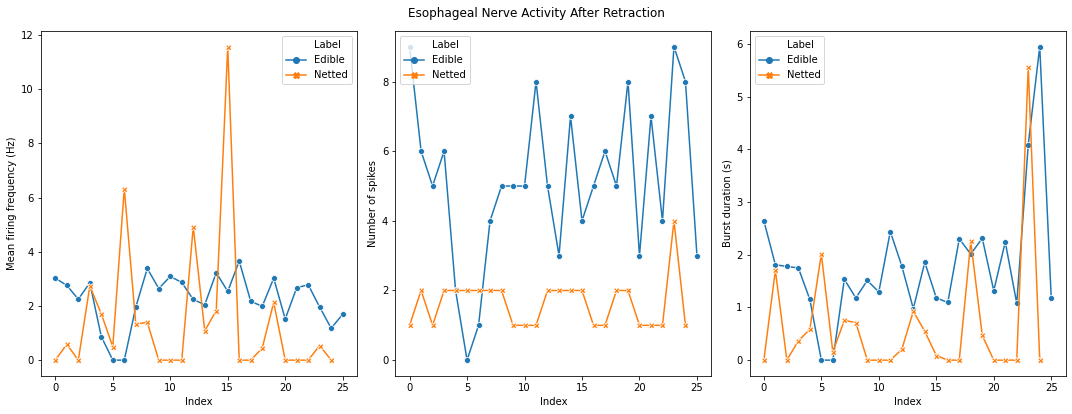

In [37]:
title = 'Esophageal Nerve Activity After Retraction'
unit = 'EN small'
columns = ['Mean firing frequency (Hz)', 'Number of spikes', 'Burst duration (s)']

fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15,6))

for i, y in enumerate(columns):
    ax = axes[i]

    # plot swallows in sequence-order
    sns.lineplot(x='Index', y=y, hue='Label', style='Label', data=df_all[df_all['Unit'] == unit], ax=ax, markers=True, dashes=False)

# add a plot title
plt.suptitle(title)

# adjust plot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

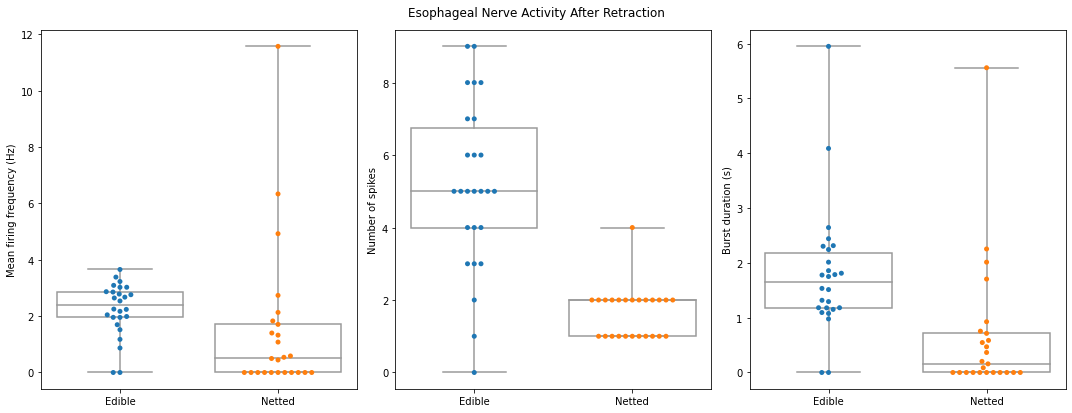

In [38]:
title = 'Esophageal Nerve Activity After Retraction'
unit = 'EN small'
columns = ['Mean firing frequency (Hz)', 'Number of spikes', 'Burst duration (s)']

fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15,6))

for i, y in enumerate(columns):
    ax = axes[i]

    # draw box-and-whisker plots
    sns.boxplot(x='Label', y=y, data=df_all[df_all['Unit'] == unit], ax=ax, color='w', whis=999) # whiskers span extrema

    # plot individual points
    sns.swarmplot(x='Label', y=y, data=df_all[df_all['Unit'] == unit], ax=ax)

    # remove the x-axis label
    ax.set_xlabel(None)

# add a plot title
plt.suptitle(title)

# adjust plot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## MCC

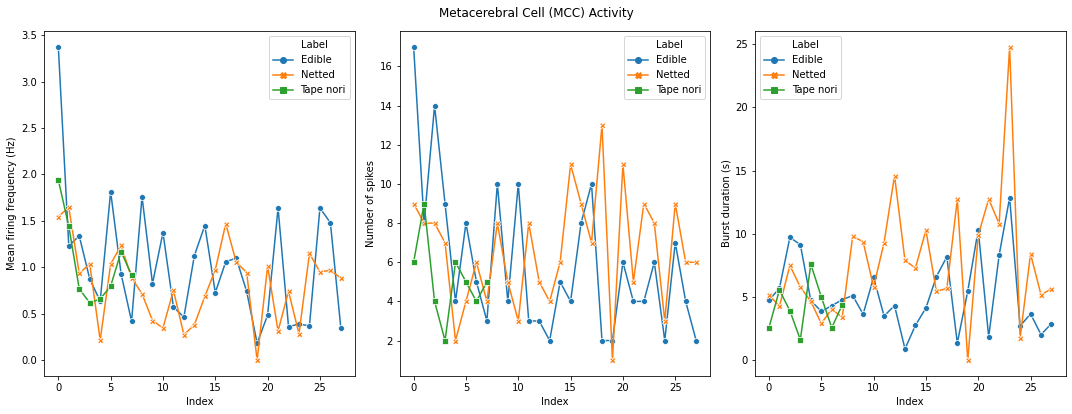

In [39]:
title = 'Metacerebral Cell (MCC) Activity'
unit = 'MCC'
columns = ['Mean firing frequency (Hz)', 'Number of spikes', 'Burst duration (s)']

fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15,6))

for i, y in enumerate(columns):
    ax = axes[i]

    # plot swallows in sequence-order
    sns.lineplot(x='Index', y=y, hue='Label', style='Label', data=df_all[df_all['Unit'] == unit], ax=ax, markers=True, dashes=False)

# add a plot title
plt.suptitle(title)

# adjust plot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

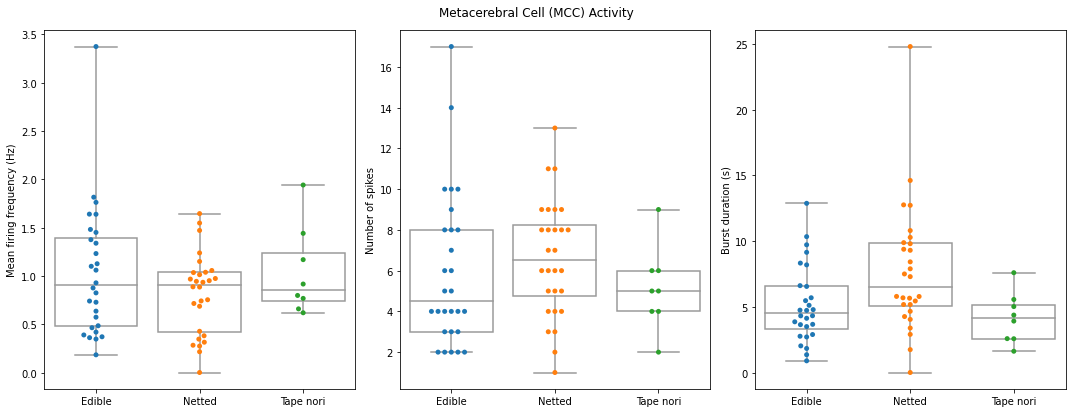

In [40]:
title = 'Metacerebral Cell (MCC) Activity'
unit = 'MCC'
columns = ['Mean firing frequency (Hz)', 'Number of spikes', 'Burst duration (s)']

fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15,6))

for i, y in enumerate(columns):
    ax = axes[i]

    # draw box-and-whisker plots
    sns.boxplot(x='Label', y=y, data=df_all[df_all['Unit'] == unit], ax=ax, color='w', whis=999) # whiskers span extrema

    # plot individual points
    sns.swarmplot(x='Label', y=y, data=df_all[df_all['Unit'] == unit], ax=ax)

    # remove the x-axis label
    ax.set_xlabel(None)

# add a plot title
plt.suptitle(title)

# adjust plot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])